In [1]:
import pandas as pd
import helper.entsoe_wrapper as entsoe_wrapper
import helper.intensity as its
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression
import numpy as np
country='ES'
start=pd.Timestamp('2022-01-01', tz='UTC')
end=pd.Timestamp('2023-01-01', tz='UTC')

In [9]:
generation_df=entsoe_wrapper.get_generation_data_1h_0(country, start, end)

In [263]:
generation_df=entsoe_wrapper.get_generation_data_1h_0(country, start, end)
generation_df=generation_df.drop(columns=['Hydro Pumped Storage_Actual Consumption'])
residual_gen_df=generation_df.drop(columns=['Other renewable_Actual Aggregated',
       'Solar_Actual Aggregated', 'Solar_Actual Consumption',
       'Waste_Actual Aggregated', 'Wind Offshore_Actual Aggregated',
       'Wind Onshore_Actual Aggregated', 'Wind Onshore_Actual Consumption'])
renewable_gen_df=generation_df.drop(columns=['Biomass_Actual Aggregated',
       'Fossil Brown coal/Lignite_Actual Aggregated',
       'Fossil Gas_Actual Aggregated', 'Fossil Hard coal_Actual Aggregated',
       'Fossil Oil_Actual Aggregated', 'Geothermal_Actual Aggregated',
       'Hydro Pumped Storage_Actual Aggregated',
       'Hydro Run-of-river and poundage_Actual Aggregated',
       'Hydro Water Reservoir_Actual Aggregated', 'Nuclear_Actual Aggregated',
       'Other_Actual Aggregated'])
emission_op=its.get_average_intensity(residual_gen_df.copy(), ifac.get_emission_op(),country)
water_op=its.get_average_intensity(residual_gen_df.copy(), ifac.get_water_op(),country)
res_share=residual_gen_df.sum(axis=1)/generation_df.sum(axis=1)*100
emissions_op_h=emission_op*residual_gen_df.sum(axis=1)
water_op_h=water_op*residual_gen_df.sum(axis=1)
generation_sum=generation_df.sum(axis=1)

KeyError: "['Solar_Actual Consumption', 'Wind Onshore_Actual Consumption'] not found in axis"

In [259]:
residual_gen_df.sum(axis=0)

Biomass_Actual Aggregated                            3.935568e+07
Fossil Brown coal/Lignite_Actual Aggregated          1.034308e+08
Fossil Gas_Actual Aggregated                         4.572368e+07
Fossil Hard coal_Actual Aggregated                   6.283861e+07
Fossil Oil_Actual Aggregated                         2.781359e+06
Geothermal_Actual Aggregated                         1.957960e+05
Hydro Pumped Storage_Actual Aggregated               1.013424e+07
Hydro Run-of-river and poundage_Actual Aggregated    1.122659e+07
Hydro Water Reservoir_Actual Aggregated              1.545985e+06
Nuclear_Actual Aggregated                            3.274058e+07
Other_Actual Aggregated                              2.298542e+06
dtype: float64

<Axes: >

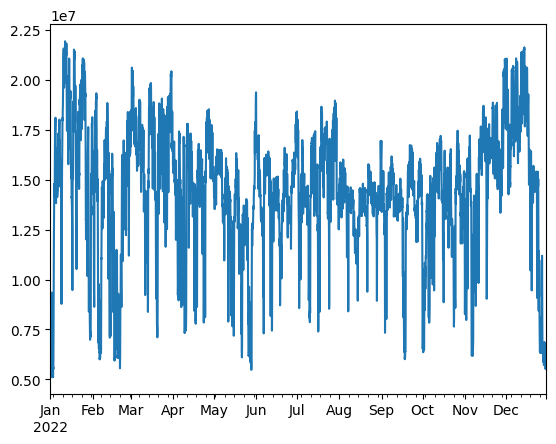

In [249]:
emissions_op_h.plot()

In [239]:
emission_delta=(emissions_op_h-emissions_op_h.shift(1)).fillna(0)
generation_delta=(residual_gen_df.sum(axis=1)-residual_gen_df.sum(axis=1).shift(1)).fillna(0)
water_delta=(water_op_h-water_op_h.shift(1)).fillna(0)

In [240]:
generation_sum=generation_sum.reset_index()
generation_sum.columns=['date','generation']
generation_sum.sort_values(by='generation', inplace=True)
generation_sum=generation_sum.reset_index(drop=True)
generation_sum["cluster"]=generation_sum.index//int(generation_sum.shape[0]/10)
generation_sum.index=generation_sum['date']
generation_sum=generation_sum.drop(columns=['date'])
generation_sum=generation_sum.sort_index()

In [241]:
# Define the number of clusters
num_clusters = 5

# Calculate the cluster for each row based on res_share
generation_sum["res_cluster"] = (res_share // (100 / num_clusters)).astype(int)

# Ensure the cluster values are within the valid range
generation_sum["res_cluster"] = generation_sum["res_cluster"].clip(0, num_clusters - 1)



In [244]:
result=np.zeros((10,5))

for i in range(10):
    for s in range(5):
        # Calculate the number of entries for each combination of clusters
        result[i][s]=generation_sum[(generation_sum["cluster"] == i) & (generation_sum["res_cluster"] == s)].shape[0]    

In [255]:
# fit a regression model and save the r2 value to a numpy array for each cluster combination with more than 50 entries and put 0 otherwise
r2=np.zeros((10,10))
for i in range(10):
    for s in range(5):
        if result[i][s]>50:
            indices = generation_sum[(generation_sum["cluster"] == i) & (generation_sum["res_cluster"] == s)].index
            X = generation_delta.loc[indices].values.reshape(-1, 1)
            y = emission_delta.loc[indices].values.reshape(-1, 1)
            reg = LinearRegression().fit(X, y)
            r2[i][s]=reg.score(X, y)

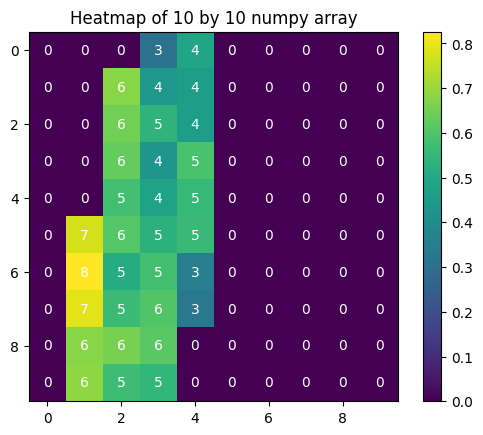

In [256]:
import matplotlib.pyplot as plt
for i in range(10):
    for j in range(10):
        plt.text(j, i, int(r2[i, j]*10), ha='center', va='center', color='white')
plt.imshow(r2, cmap='viridis', interpolation='nearest')
plt.colorbar()
plt.title('Heatmap of 10 by 10 numpy array')
plt.show()

In [106]:
X=generation_delta.values.reshape(-1,1)
y=water_delta.values.reshape(-1,1)
model = LinearRegression(fit_intercept=False)
model.fit(X,y)
pred = model.predict(X)
print('Bestimmungsmaß R²: ' + str(round(model.score(X,y),3)))
print('Steigung: ' + str(np.around(model.coef_.item(), decimals=3)))
print('Intercept: ' + str(model.intercept_))

Bestimmungsmaß R²: 0.824
Steigung: 2.529
Intercept: 0.0
